In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from spectraltools import Spectral
from tensorflow import keras

In [6]:
#Spectral NN model

def spectral_model():
    mod = tf.keras.Sequential()
    mod.add(tf.keras.Input(shape=(x_train.shape[1])))
    mod.add(Spectral(units=100,
                     is_base_trainable=True,
                     is_diag_end_trainable=False,
                     is_diag_start_trainable=True,
                     activation='tanh',
                     use_bias=True,
                     diag_end_initializer='Zeros',
                     diag_start_initializer='Ones',
                     diag_regularizer=tf.keras.regularizers.L2(l2=1e-6),
                     base_regularizer=tf.keras.regularizers.L2(l2=1e-4)))
    mod.add(tf.keras.layers.BatchNormalization())
    mod.add(tf.keras.layers.Dropout(0.2))
    mod.add(Spectral(units=100,
                     is_base_trainable=True,
                     is_diag_end_trainable=False,
                     is_diag_start_trainable=True,
                     activation='relu',
                     use_bias=True,
                     diag_end_initializer='Zeros',
                     diag_start_initializer='Ones'))
    mod.add(Spectral(units=50,
                     is_base_trainable=True,
                     is_diag_end_trainable=False,
                     is_diag_start_trainable=True,
                     activation='relu',
                     use_bias=True,
                     diag_end_initializer='Zeros',
                     diag_start_initializer='Ones'))
    mod.add(Spectral(2,
                     is_base_trainable=True,
                     is_diag_end_trainable=False,
                     is_diag_start_trainable=True,
                     activation='softmax',
                     use_bias=True,
                     diag_end_initializer='Zeros',
                     diag_start_initializer='Ones'))
    return mod
#%%

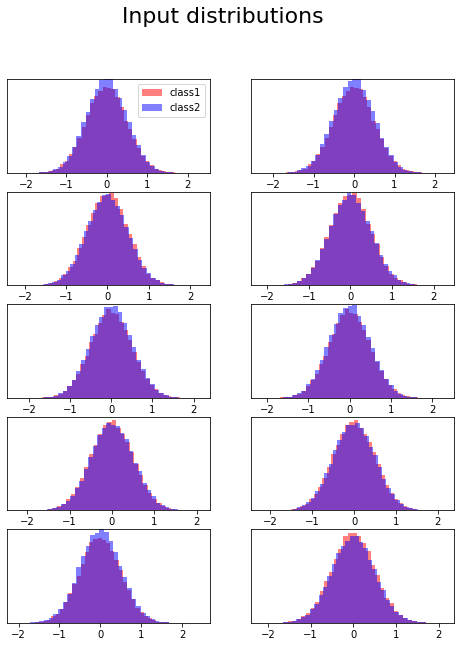

Epoch 1/5
144/144 [==============================] - 2s 5ms/step - loss: 0.1461 - accuracy: 0.9555 - val_loss: 0.1668 - val_accuracy: 0.9556
Epoch 2/5
144/144 [==============================] - 1s 4ms/step - loss: 0.0983 - accuracy: 0.9750 - val_loss: 0.1054 - val_accuracy: 0.9794
Epoch 3/5
144/144 [==============================] - 1s 4ms/step - loss: 0.0918 - accuracy: 0.9770 - val_loss: 0.1265 - val_accuracy: 0.9722
Epoch 4/5
144/144 [==============================] - 1s 4ms/step - loss: 0.0850 - accuracy: 0.9792 - val_loss: 0.0768 - val_accuracy: 0.9831
Epoch 5/5
625/625 [==============================] - 1s 1ms/step - loss: 0.1193 - accuracy: 0.9743


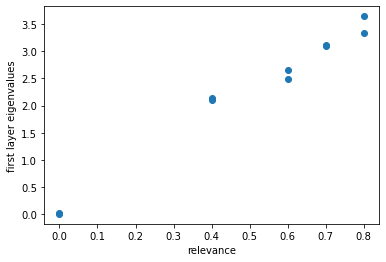

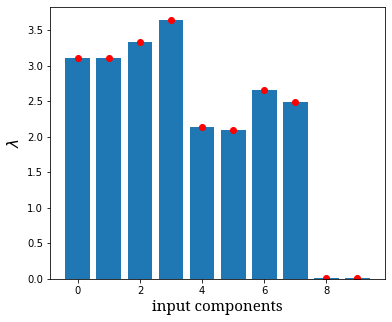

In [9]:
# Correlated gaussian distributions dataset

n_feature = 10
n_relevant = 8
n_examples = 100000
n_classes = 2
sigma = 0.5
mu = 0

x = np.zeros((n_examples, n_feature))
y = np.random.randint(0,n_classes, n_examples)

rk_corr = [0.7,0.8,0.4,0.6]
relative_relevance = rk_corr

for f in range(int(n_relevant/2)):

    x[:,2*f] = np.random.normal(mu, sigma, len(y))
    bin_cl1 = np.random.choice([0,1], len(y[y==1]), p=[1-rk_corr[f], rk_corr[f]])
    x[y==0,2*f+1] = x[y==0,2*f].copy()
    x[y==1,2*f+1] = (1-bin_cl1) * x[y==1,2*f] - bin_cl1 * x[y==1,2*f]

for f in range(n_relevant, n_feature):
    x[:,f] = np.random.normal(mu, sigma, len(y))
    x[:,f] = np.random.normal(mu, sigma, len(y))



x_train, x_test = x[:int(x.shape[0]*0.8)], x[int(x.shape[0]*0.8):]
y_train, y_test = y[:int(y.shape[0]*0.8)], y[int(y.shape[0]*0.8):]


cl0 = x[y == 0]
cl1 = x[y == 1]
fig, ax = plt.subplots(5, 2, figsize=(8, 10))
fig.suptitle('Input distributions', fontsize=22)
i = 0
for r in range(5):
    for c in range(2):
        if i < x.shape[1]:
            ax[r, c].hist(cl0[:, i], 40, color='r', alpha=0.5)
            ax[r, c].hist(cl1[:, i], 40, color='b', alpha=0.5)
            #f c != 0:
            ax[r, c].tick_params(left=False)  # remove the ticks
            ax[r, c].set_yticklabels([])
            ax[r, c].set_ylim([0, 4500])
        i += 1
    ax[0,0].legend(['class1', 'class2'])
plt.show()



In [ ]:
# Training and results



list_results=[]
list_accuracy=[]
for i in range(1):
    mod = spectral_model()
    mod.compile(
        optimizer=tf.keras.optimizers.Adam(0.01),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics='accuracy',
    )
    hist = mod.fit(x_train, y_train,
                   batch_size=500,
                   epochs=5, #500
                   validation_split=0.1,
                   verbose=1)

    eig_start = Spectral.return_diag(mod.layers[0])
    base_start = mod.layers[0].base
    norma = tf.linalg.norm(base_start, ord=2, axis=1)
    eig_norm = (eig_start * norma)
    list_results.append(eig_norm)
    list_accuracy.append(mod.evaluate(x_test,y_test)[1])



arr = np.zeros((len(list_results), list_results[0].shape[0]))
for i in range(len(list_results)):
    arr[i,:] = np.abs(list_results[i].numpy())

mean = arr.mean(axis=0)
std = arr.std(axis=0)


for_plot = []
for i in range(len(relative_relevance)):
    for_plot.append(relative_relevance[i])
    for_plot.append(relative_relevance[i])
for i in range(n_relevant,n_feature):
    for_plot.append(0)

mean = arr.mean(axis=0)
std = arr.std(axis=0)


plt.figure()
plt.errorbar(for_plot, mean, yerr=std, marker='o', linestyle='none')
plt.xlabel('relevance')
plt.ylabel('first layer eigenvalues')
plt.show()


plt.figure(figsize=(6, 5))
plt.bar(np.arange(n_feature), mean)
plt.errorbar(np.arange(n_feature), mean, yerr=std, marker='o', linestyle='none', color='r')
plt.xlabel('input components', **{'fontname':'Noto Serif'}, fontsize=15)
plt.ylabel(r'$\lambda$' ,**{'fontname':'Noto Serif'}, fontsize=15)
plt.show()
